<a href="https://colab.research.google.com/github/TatyanaLanceva/Netology/blob/main/5_3_Hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ## Домашнее задание Проверка гипотез

In [ ]:
# Загружаем библиотеки:
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import rankdata
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.stats.multicomp as mc
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


<div class="alert alert-info">
<b>Задание № 1</b>
    
Разработайте функцию для проверки нормальности распределения выборки данных, используя шаблон ниже. Вы можете использовать один из известных Вам статистических тестов.
</div>

In [ ]:
# Для проверки распределения используем критерий Шапиро-Уилка, предположим, что наблюдений до 5000.

def check_normality(data):
    stat, p = shapiro(data)
    alpha = 0.05
    if p < alpha:
        print ("Отклоняем нулевую гипотезу >> Данные распределены не нормально")
    else:
        print("Не отклоняем нулевую гипотезу >> Данные распределены нормально")

<div class="alert alert-info">
<b>Задание № 2</b>

Даны две выборки роста мужчин и женщин.
- Докажите, используя `t-Тест Стьюдента`, что различие между выборками незначительно, если уровень значимости равен $\alpha$ `= 0.001`.
- Покажите различия визуально
- Является ли результат полезным с практической точки зрения? Почему да или нет?
</div>

In [ ]:
np.random.seed(42) # фиксация случайности
# Сократим выборку для упрощения расчетов и увеличения чувствительности теста.
men  = stats.norm.rvs(loc=171, scale=10, size=150000)  # Выборка мужчин со средним ростом 171
women = stats.norm.rvs(loc=170, scale=10, size=150000)  # Выборка женщин со средним ростом 170

# Берем подвыборки размером 1000
sample_men = men[:1000]
sample_women = women[:1000]

# Проводим t-теста Стьюдента:
t_statistic, p_value = stats.ttest_ind(sample_men, sample_women)

# Анализируем результат, проверим, является ли p-значение меньше установленного уровня значимости (α=0,001).
alpha = 0.001
if p_value < alpha:
    print(f'Различие между выборками значительно (p = {p_value:.3f}).')
else:
    print(f'Различие между выборками незначительно (p = {p_value:.3f}).')

Различие между выборками незначительно (p = 0.002).


In [ ]:
# Посчитаем дисперсии
dispersion_men = np.var(sample_men, ddof=1)  # Дисперсия для мужчин
dispersion_women = np.var(sample_women, ddof=1)  # Дисперсия для женщин

print(f"Дисперсия для мужчин: {dispersion_men:.3f}")
print(f"Дисперсия для женщин: {dispersion_women:.3f}")

Дисперсия для мужчин: 95.886
Дисперсия для женщин: 96.039


Можно сделать выводы, что дисперсии близки, разница между ними крайне мала. Соответственно использование t-теста Стьюдента допустимо.

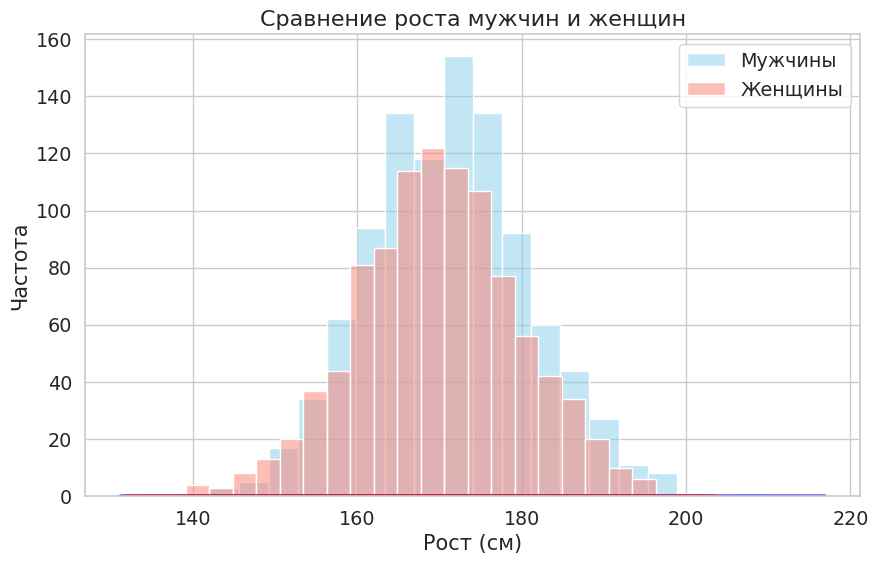

In [ ]:
data = pd.DataFrame({
    'Группа': ['Мужчины'] * len(sample_men) + ['Женщины'] * len(sample_women),
    'Рост': np.concatenate([sample_men, sample_women])
})

# Построим гистограммы с наложением для изучения распределения по двум группам
sns.set(style="whitegrid", font_scale=1.25)

fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data.query("Группа == 'Мужчины'"), x='Рост', ax=ax, color='skyblue', alpha=0.5, label='Мужчины', bins=20)
sns.histplot(data.query("Группа == 'Женщины'"), x='Рост', ax=ax, color='salmon', alpha=0.5, label='Женщины', bins=20)

sns.kdeplot(data.query("Группа == 'Мужчины'"), x='Рост', ax=ax, color='blue', linewidth=2.5, label=None)
sns.kdeplot(data.query("Группа == 'Женщины'"), x='Рост', ax=ax, color='red', linewidth=2.5, label=None)

ax.legend(title='', loc='upper right')
ax.set_xlabel('Рост (см)')
ax.set_ylabel('Частота')
ax.set_title("Сравнение роста мужчин и женщин", fontsize=16)

plt.show()

Сделаем выводы по исследованию. t-Тест Стьюдента при уровне значимости α = 0,001 показывает незначительные различия между выборками. При изучении гистограмм распределения мы видим, что оба графика имеют нормальное распределение. Средний рост мужчин немного выше среднего роста женщин. Размах значений роста для обоих полов примерно одинаков, это видно по близкой ширине гистограмм.  

Используем для исследования t-тест Уэлча для полных выборок. Его преимущества:
*   Тест Уэлча помогает избежать ошибок, связанных с возможным неравенством дисперсий
*   T-тест Уэлча более устойчив к таким ситуациям и дает более точные результаты
*   Точность на небольших выборках



In [ ]:
# Выполним t-тест Уэлча
mean_men, std_men = np.mean(sample_men), np.std(sample_men, ddof=1)
mean_women, std_women = np.mean(sample_women), np.std(sample_women, ddof=1)
n_men, n_women = len(sample_men), len(sample_women)
t_statistic, p_value = stats.ttest_ind_from_stats(
    mean1=mean_men,
    std1=std_men,
    nobs1=n_men,
    mean2=mean_women,
    std2=std_women,
    nobs2=n_women,
    equal_var=False  # учитываем возможное неравенство дисперсий
)
# альфа согласно условию задания
alpha = 0.001
# интерпретация:
if p_value < alpha:
    print(f'Различие между выборками значительно (p = {p_value:.5f}).')
else:
    print(f'Различие между выборками незначительно (p = {p_value:.5f}).')

Различие между выборками незначительно (p = 0.00165).


По результатам t-теста Уэлча, если p-значение меньше 0,001, то различие между выборками считается значимым. В вашем случае p-значение равно 0,00165, что больше установленного уровня значимости (0,001), следовательно, различие между выборками незначительно.

<div class="alert alert-info">
<b>Задание № 3</b>

Специалист по кадрам, работающий в технологической компании, интересуется сверхурочным временем разных команд. Чтобы выяснить, есть ли разница между сверхурочной работой команды разработчиков программного обеспечения и группы тестирования, она случайным образом выбрала 17 сотрудников в каждой из двух команд и записала их среднее сверхурочное время за неделю в пересчете на час. Данные ниже.

В соответствии с этой информацией проведите проверку гипотезы, чтобы проверить, есть ли разница между переутомлением двух команд, используя уровень значимости 0,05. Прежде чем приступать к проверке гипотез, проверьте предположение нормальности.
</div>

In [ ]:
test_team = [6.2, 7.1, 1.5, 2,3 , 2, 1.5, 6.1, 2.4, 2.3, 12.4, 1.8, 5.3, 3.1, 9.4, 2.3, 4.1]
developer_team = [2.3, 2.1, 1.4, 2.0, 8.7, 2.2, 3.1, 4.2, 3.6, 2.5, 3.1, 6.2, 12.1, 3.9, 2.2, 1.2 ,3.4]

In [ ]:
# Проверим нормальность с помощью теста Шапиро-Уилка и сделаем выводы
# Для проверки можно использовать функцию, написанную к первому заданию, используем ее для наших выборок:

check_normality(test_team)
check_normality(developer_team)

Отклоняем нулевую гипотезу >> Данные распределены не нормально
Отклоняем нулевую гипотезу >> Данные распределены не нормально


Поскольку оба набора данных не соответствуют нормальному распределению, использование параметрических методов анализа, таких как t-тест Стьюдента, будет некорректным. Вместо этого следует применять непараметрические методы, такие как U-критерий Манна-Уитни для сравнения медиан двух независимых выборок.

Сформулируем нулевую гипотезу:
Н0: Медианы сверхурочных часов команд разработчиков и тестировщиков одинаковы
Соответственно альтернативная гипотеза будет:
Н1: Медианы сверхурочных часов команд разработчиков и тестировщиков отличаются

In [ ]:
U, p_val = mannwhitneyu(test_team, developer_team)
print("U-критерий Манна-Уитни:")
print(f"У-статистика: {U:.3f}")
print(f"П-значение: {p_val:.3f}")

U-критерий Манна-Уитни:
У-статистика: 151.500
П-значение: 0.823


Выводы:
Так как p-значение (0,823) значительно выше уровня значимости alpha = 0,05, мы не можем отвергнуть нулевую гипотезу. Это говорит о том, что нет статистически значимых доказательств, подтверждающих существование разницы между медианами сверхурочных часов команд разработчиков и тестировщиков.

Таким образом, между этими двумя группами нет существенной разницы в уровне сверхурочной работы.

<div class="alert alert-info">
<b>Задание № 4</b>

Педиатр хочет увидеть влияние потребления смеси на среднемесячную прибавку в весе у новорожденных. По этой причине она собрала данные из трех разных групп. Первая группа – дети исключительно грудного вскармливания, вторая группа – дети, которых кормят только смесью, и последняя группа – это дети, находящиеся на искусственном вскармливании и на грудном вскармливании. Эти данные приведены ниже.

В соответствии с этой информацией проведите проверку гипотезы, чтобы проверить, есть ли разница между среднемесячным приростом этих трех групп, используя уровень значимости 0,05. Если есть значительная разница, выполните дальнейший анализ, чтобы найти причину разницы.
</div>

In [ ]:
only_breast = [794.1, 716.9, 993. , 724.7, 760.9, 908.2, 659.3 , 690.8, 768.7, 717.3 , 630.7, 729.5, 714.1, 810.3, 583.5, 679.9, 865.1];
only_formula = [898.8, 881.2, 940.2, 966.2, 957.5, 1061.7, 1046.2, 980.4, 895.6, 919.7, 1074.1, 952.5, 796.3, 859.6, 871.1 , 1047.5, 919.1 , 1160.5, 996.9];
both = [976.4, 656.4, 861.2, 706.8, 718.5, 717.1, 759.8, 894.6, 867.6, 805.6, 765.4, 800.3, 789.9, 875.3, 740. , 799.4, 790.3, 795.2 , 823.6, 818.7, 926.8, 791.7, 948.3];

Сформулируем нулевую гипотезу:

Н0: Между всеми тремя группами (грудное,искусственное и смешанное вскармливание) нет значимых различий в средней месячной прибавке в весе.

In [ ]:
# Для проверки нормальности распределения мы снова используем нашу функцию из первого задания
print("Грудное вскармливание:")
check_normality(only_breast)

print("\nИскусственное вскармливание:")
check_normality(only_formula)

print("\nСмешанное вскармливание:")
check_normality(both)

Грудное вскармливание:
Не отклоняем нулевую гипотезу >> Данные распределены нормально

Искусственное вскармливание:
Не отклоняем нулевую гипотезу >> Данные распределены нормально

Смешанное вскармливание:
Не отклоняем нулевую гипотезу >> Данные распределены нормально


In [ ]:
# проверим гомоскедастичность с использованием теста Левена
# Тестируем все три группы одновременно
levene_result = levene(only_breast, only_formula, both)
print(levene_result)

LeveneResult(statistic=0.266118612498075, pvalue=0.7673118764998224)


p-значение значительно выше 0.05, предположение о равенстве дисперсий выполняется

In [ ]:
f_statistic, p_value = f_oneway(only_breast, only_formula, both)
print(f"Статистика F: {f_statistic:.4f}, p-значение: {p_value:.4f}")

Статистика F: 26.7013, p-значение: 0.0000


Поскольку p-значение значительно меньше уровня значимости 0.05, мы отвергаем нулевую гипотезу о том, что все три группы имеют одинаковые средние значения прироста веса. Это означает, что хотя бы одна пара групп имеет существенно разные средние значения. Требуется дальнейший анализ


In [ ]:
f_statistic, p_value = f_oneway(only_breast, only_formula, both)
print(f"Статистика F: {f_statistic:.4f}, p-значение: {p_value:.4f}")

Статистика F: 26.7013, p-значение: 0.0000


Так как p-значение намного меньше уровня значимости 0,05, мы отвергаем нулевую гипотезу о том, что все три группы имеют одинаковые средние значения прироста веса. Это значит, что хотя бы одна пара групп имеет существенно разные средние значения. Для точного выявления конкретных пар групп, которые отличаются друг от друга, следует провести дополнительные тесты, такие как тест Тьюки. Это поможет понять, какие именно группы имеют наибольшие различия.

In [ ]:
data = {
    'weight_gain': only_breast + only_formula + both,
    'group': ['breast'] * len(only_breast) +
             ['formula'] * len(only_formula) +
             ['mixed'] * len(both)
}
df = pd.DataFrame(data)
# Выполним тест Тьюки
tukey_results = pairwise_tukeyhsd(
    endog=df['weight_gain'],
    groups=df['group'],
    alpha=0.05
)
print(tukey_results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower    upper   reject
----------------------------------------------------------
 breast formula  209.3923    0.0  137.3508 281.4337   True
 breast   mixed   60.1286 0.0995   -8.8912 129.1485  False
formula   mixed -149.2636    0.0 -216.1621 -82.3651   True
----------------------------------------------------------


Таким образом, можно сделать следующие выводы:группы "breast" и "formula" имеют значительные различия в среднем значении. Группы "breast" и "mixed" не показывают значительных различий в среднем значении. Группы "formula" и "mixed" имеют значительные различия в среднем значении.


<div class="alert alert-info">
<b>Задание № 5 (Опционально) </b>

Аналитик финансовой инвестиционной компании интересуется взаимосвязью между полом и склонностью к риску. Из базы данных была взята случайная выборка из 660 клиентов. Клиенты в выборке были классифицированы в соответствии с их полом и склонностью к риску. Результат приведен в следующей таблице.
    
Проверьте гипотезу о том, что склонность к риску клиентов этой компании не зависит от их пола. Используйте α = 0.01.    
</div>

In [ ]:
contingency_table = pd.DataFrame(
    [
        [53, 23, 30, 36, 88],
        [71, 48, 51, 57, 203]
    ],
    #columns = ['Machine Learning', 'Data Science', 'Analytics'],
    index = ['Ж', 'М'])

print('Уровень риска')
print(contingency_table)

Уровень риска
    0   1   2   3    4
Ж  53  23  30  36   88
М  71  48  51  57  203


Сформулируем нулевую гипотезу:

Н0: Склонность к риску не зависит от пола.

In [ ]:
# Проведение теста хи-квадрат
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Результаты
print("Результаты теста:")
print(f"Статистика хи-квадрат: {chi2:.2f}")
print(f"P-значение: {p_value:.6f}")
print(f"Степени свободы: {dof}")

# Интерпретация результатов
if p_value < 0.01:
    print("\nОтвергаем нулевую гипотезу.")
else:
    print("\nНе отвергаем нулевую гипотезу.")

Результаты теста:
Статистика хи-квадрат: 7.09
P-значение: 0.130992
Степени свободы: 4

Не отвергаем нулевую гипотезу.


Соответственно мы принимаем нулевую гипотезу и то, что сколнность к риску не зависит от пола.

<div class="alert alert-info">
<b>Задание № 6 (Опционально)</b>

Компания электронной коммерции регулярно размещает рекламу своих кампаний на YouTube, Instagram и Facebook. Однако новому менеджеру было любопытно, есть ли разница между количеством клиентов, привлеченных этими платформами. Поэтому она начала использовать Adjust — приложение, позволяющее узнать, откуда приходят ваши пользователи. Ежедневные цифры, сообщаемые Adjust для каждой платформы, приведены ниже.
    
В соответствии с этой информацией проведите проверку гипотез, чтобы проверить, есть ли разница между средним числом привлеченных клиентов на этих трех платформах с использованием уровня значимости 0,05. Если есть значительная разница, выполните дальнейший анализ, чтобы найти причину разницы. Прежде чем приступать к проверке гипотез, проверьте соответствующие предположения.
</div>

In [ ]:
youtube=[1913, 1879, 1939, 2146, 2040, 2127, 2122, 2156, 2036, 1974, 1956, 2146, 2151, 1943, 2125]
instagram = [2305., 2355., 2203., 2231., 2185., 2420., 2386., 2410., 2340., 2349., 2241., 2396., 2244., 2267., 2281.]
facebook = [2133., 2522., 2124., 2551., 2293., 2367., 2460., 2311., 2178., 2113., 2048., 2443., 2265., 2095., 2528.]

In [ ]:
# Для проверки нормальности распределения используем нашу функцию из 1 задания, проверяющую данные по критерию Шапиро-Уилка:

check_normality(youtube)
check_normality(instagram)
check_normality(facebook)

Отклоняем нулевую гипотезу >> Данные распределены не нормально
Не отклоняем нулевую гипотезу >> Данные распределены нормально
Не отклоняем нулевую гипотезу >> Данные распределены нормально


Исходя из результатов проверки нормальности, видно, что данные по платформе YouTube не соответствуют нормальному распределению, тогда как данные по Instagram и Facebook распределены нормально. Поскольку одно из распределений не соответствует нормальному закону, применим тест Краскела-Уоллиса, который подходит для сравнения медиан нескольких независимых выборок без требования нормальности.

Сформулируем нулевую гипотезу:

Н0: Медианы всех трёх выборок (youtube, instagram, facebook) одинаковы.

In [ ]:
kruskal_statistic, pvalue = kruskal(youtube, instagram, facebook)

if pvalue < 0.05:
    print("Есть значительные различия между медианами (p-value = {:.6f})".format(pvalue))
else:
    print("Нет значительных различий между медианами (p-value = {:.6f})".format(pvalue))

Есть значительные различия между медианами (p-value = 0.000015)


Поскольку тест Краскела-Уоллиса выявил значимые различия между медианами трёх выборок, следующий шаг — проведение пост-хок анализа для определения, какие конкретно пары выборок отличаются друг от друга.

In [ ]:
# Объединенные данные
data = youtube + instagram + facebook

# Метки для каждой группы
groups = ["YouTube"] * len(youtube) + ["Instagram"] * len(instagram) + ["Facebook"] * len(facebook)

# Выполнение теста Данна
comparisons = mc.pairwise_tukeyhsd(data, groups, alpha=0.05)

# Вывод результатов
print(comparisons.summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1    group2   meandiff p-adj    lower     upper   reject
---------------------------------------------------------------
 Facebook Instagram   12.1333 0.9619  -98.8691  123.1358  False
 Facebook   YouTube -251.8667    0.0 -362.8691 -140.8642   True
Instagram   YouTube    -264.0    0.0 -375.0024 -152.9976   True
---------------------------------------------------------------


Выводы:     

Нет статистически значимых различий между средними значениями групп Facebook и Instagram. Есть статистически значимые различия между средними значениями групп Facebook и YouTube, причем среднее значение группы YouTube значительно ниже, чем у группы Facebook. Также имеются статистически значимые различия между средними значениями групп Instagram и YouTube, причем среднее значение группы YouTube значительно ниже, чем у группы Instagram.

# **Примечание:**

Домашнее задание сдается ссылкой [Google Colab](https://colab.research.google.com/). Мы не сможем проверить его или помочь, если вы пришлете:

*   файлы;
*   архивы;
*   скриншоты кода.

Все обсуждения и консультации по выполнению домашнего задания ведутся только на соответствующем канале в Discord.

**Как правильно задавать вопросы аспирантам, преподавателям и коллегам:**

Прежде чем задать вопрос, попробуйте найти ответ в интернете. Навык самостоятельного поиска информации — один из важнейших. Каждый практикующий специалист любого уровня делает это ежедневно.

Сформулируйте вопрос по алгоритму:

1.   Что я делаю?
2.   Какого результата я ожидаю?
3.   Как фактический результат отличается от ожидаемого?
4.   Что я уже попробовал сделать, чтобы исправить проблему?

По возможности прикрепите к вопросу скриншоты либо ссылки на код. Не выкладывайте все решение, оставляйте только проблемный и воспроизводимый участок кода.